* 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?  
* 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?  
* 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?  

#### 방법
* 아주 다양하게 데이터를 탐색해 본 커널도 있고, 상위권을 달성한 커널은 오늘 다루지 않은 스태킹 앙상블(stacking ensemble) 등의 기법을 활용한 커널을 활용하기도 합니다. 한 번씩 구경해보고 다른 사람들은 어떤 전략으로 성능을 끌어올렸는지 공부해보는 것도 매우 좋을 겁니다!

* 여러 가지 실험을 해보고 결과 csv는 캐글에, 사용한 노트북은 깃허브(GitHub)를 통해 이곳에 제출해 주세요. 제출한 노트북에는 본인의 캐글 Submission 스코어를 기재해 주시기 바랍니다.

In [16]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

In [17]:
data_dir = os.getenv('HOME') + '/aiffel/kaggle_kakr_housing/data/'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [18]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
test = pd.read_csv(sub_data_path)

print(f'train data dim : {data.shape}')
print(f'sub data dim : {sub.shape}')

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [19]:
y = data['price']
del data['price']


In [20]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)   # 한번에 작업하기 위해 data sub 병합

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   bedrooms       21503 non-null  int64  
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  int64  
 5   sqft_lot       21503 non-null  int64  
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  int64  
 12  sqft_basement  21503 non-null  int64  
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_li

In [22]:
sub_id = data['id'][train_len:]
del data['id']

In [23]:
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(int)
data.head()

# 기타 로그변환 전처리는 값 자체의 스케일링 작업이므로 적용하지않음

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [24]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]
print(data.shape)
print(sub.shape)

(21503, 19)
(6468, 19)


In [25]:
'''
#gboost, xgboost, lightgbm
gboost = GradientBoostingRegressor(random_state=2023)
param_grid_g = {
    
    'n_estimators': [1000,2000,4000], # 트리 갯수
    'max_depth': [5], # 트리 최대 깊이
}
grid_g = GridSearchCV(gboost, param_grid=param_grid_g, \
                        scoring='neg_root_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
grid_g.fit(x, y)
'''

"\n#gboost, xgboost, lightgbm\ngboost = GradientBoostingRegressor(random_state=2023)\nparam_grid_g = {\n    \n    'n_estimators': [1000,2000,4000], # 트리 갯수\n    'max_depth': [5], # 트리 최대 깊이\n}\ngrid_g = GridSearchCV(gboost, param_grid=param_grid_g,                         scoring='neg_root_mean_squared_error',                         cv=5, verbose=1, n_jobs=5)\ngrid_g.fit(x, y)\n"

In [26]:
'''params = grid_g.cv_results_['params']
params

score = grid_g.cv_results_['mean_test_score'] #캐글내 점수인 RMSE 출력
score

results = pd.DataFrame(params)
results['score'] = score
results'''

"params = grid_g.cv_results_['params']\nparams\n\nscore = grid_g.cv_results_['mean_test_score'] #캐글내 점수인 RMSE 출력\nscore\n\nresults = pd.DataFrame(params)\nresults['score'] = score\nresults"

* n_estimators 고정일때 max_depth = 3,5,7의 앞자리 126,121,126 로 5에서 가장 최적
* max_depth 5로 고정 후 n_estimators 조절
* n_estimators가 커짐에 따라 감소
* lgbm에 비해 무거워서 상대적으로 가벼운 lgbm으로 최적화 실행


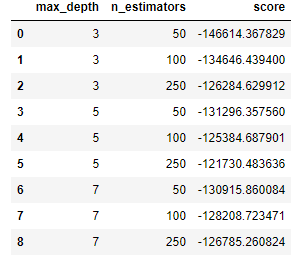

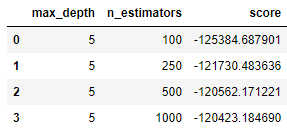

In [27]:
'''rdforest = RandomForestRegressor(random_state=2023)

param_grid_r = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 50],
}
grid_r = GridSearchCV(rdforest, param_grid=param_grid_r, \
                        scoring='neg_root_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
grid_r.fit(x, y)

params = grid_r.cv_results_['params']
params
'''

"rdforest = RandomForestRegressor(random_state=2023)\n\nparam_grid_r = {\n    'n_estimators': [100, 200],\n    'max_depth': [10, 20, 50],\n}\ngrid_r = GridSearchCV(rdforest, param_grid=param_grid_r,                         scoring='neg_root_mean_squared_error',                         cv=5, verbose=1, n_jobs=5)\ngrid_r.fit(x, y)\n\nparams = grid_r.cv_results_['params']\nparams\n"

In [28]:
'''score = grid_r.cv_results_['mean_test_score']
score

results = pd.DataFrame(params)
results['score'] = score
results'''

"score = grid_r.cv_results_['mean_test_score']\nscore\n\nresults = pd.DataFrame(params)\nresults['score'] = score\nresults"

* m, n_e 증가함에 따라 점수 개선
* m, n_E를 증가시켰으나, 점수가 12만 근처로 개선되지 않음 탈락

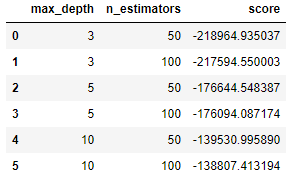

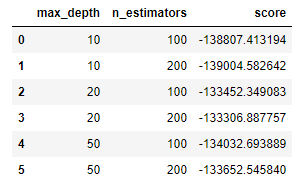

In [30]:
lightgbm = lgb.LGBMRegressor(random_state=2023)

param_grid_l = {
    'n_estimators': [2000], # 트리 갯수
    'max_depth': [5], # 트리 깊이
    'learning_rate': [0.05], # 학습률
    'num_leaves' : [17], # 트리의 리프 갯수
    'feature_fraction': [0.75] # 개별 트리 학습시 선택하는 피쳐비율

} 
grid_l = GridSearchCV(lightgbm, param_grid=param_grid_l, \
                        scoring='neg_root_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)
grid_l.fit(x, y)

params = grid_l.cv_results_['params']
params

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] feature_fraction is set=0.75, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.75


[{'feature_fraction': 0.75,
  'learning_rate': 0.05,
  'max_depth': 5,
  'n_estimators': 2000,
  'num_leaves': 17}]

In [31]:
score = grid_l.cv_results_['mean_test_score']
score

results = pd.DataFrame(params)
results['score'] = score
results

,feature_fraction,learning_rate,max_depth,n_estimators,num_leaves,score
0,0.75,0.05,5,2000,17,-120800.529716


* m이 3일때 점수가 낮음 -- 제외
* n_e가 커질수록 점수 개선
* n_e가 커질때 m이 5일때가 가장 점수 최적 -- m은 5로 Fix
* n_e가 커지면 점수 개선


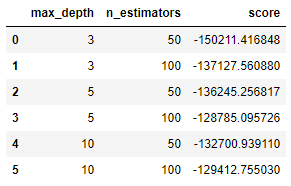

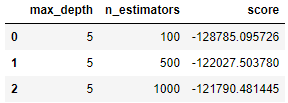

* n_e가 1000보다 증가하면 다시 점수 악화

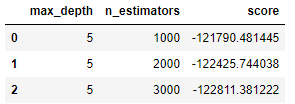

* lr을 줄인결과 n_e를 증가해도 점수가 상승한다

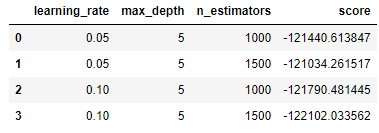

* lr = 0.01땐 n_e가 클수록 점수 개선되나 0.05일땐 n_e = 2000 일때 최적
* n_e를 너무 늘리면 학습시간이 오래걸리므로 lr=0.05, n_e = 2000으로 고정

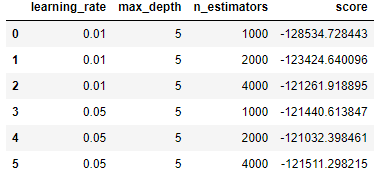

* num_leaves 가 15 근처에서 최적  // 17에서 최적

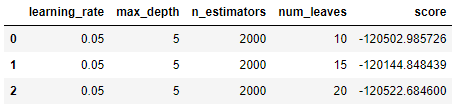
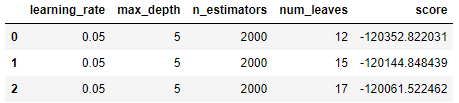

* feature_fraction 튜닝, 각 트리에서 0.75씩 추출할때 최적 
* bagging_fractio 튜닝은 점수에 변화 없음

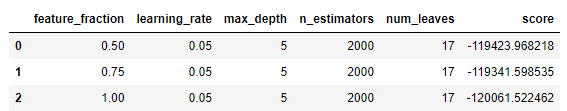

* lr = 0.02 e_n 8000일때 최적

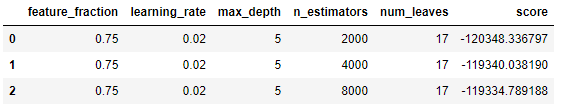


In [47]:
lightgbm = lgb.LGBMRegressor(random_state=2023, # 올해는 2023년!
     n_estimators=2000, # 트리 갯수
     max_depth=5, # 트리 깊이
     learning_rate=0.05, # 학습률
     num_leaves=17 # 트리의 리프 갯수
                            )
lightgbm.fit(x,y)

LGBMRegressor(learning_rate=0.05, max_depth=5, n_estimators=2000, num_leaves=17,
              random_state=2023)

In [48]:
y_pred_best1= lightgbm.predict(sub.values) # 모델 예측값 출력

In [49]:
result = pd.DataFrame({  # 저장
    'id' : sub_id, 
    'price' : y_pred_best1
})

result.head()

my_submission_path = join(data_dir, 'Aiffel_ex4_best2.csv')
result.to_csv(my_submission_path, index=False)
print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/Aiffel_ex4_best2.csv
